In [1]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2023 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
###############################################################################

In [2]:
import numpy as np
import time

In [3]:
from pyomo.environ import (
    ConcreteModel,
    TransformationFactory,
    SolverFactory,
    Var,
    value,
    units as pyunits,
)

In [4]:
from idaes.core import FlowsheetBlock, EnergyBalanceType
import idaes.core.solvers.petsc as petsc  # PETSc utilities module
from idaes.core.util import scaling as iscale
from idaes.core.solvers import get_solver
from idaes.core.util.model_statistics import degrees_of_freedom
import idaes.logger as idaeslog
import logging

In [5]:
from idaes.models_extra.gas_solid_contactors.unit_models.fixed_bed_1D import FixedBed1D
from idaes_examples.mod.co2_adsorption_desorption.NETL_32D_gas_phase_thermo import (
    GasPhaseParameterBlock,
)
from idaes_examples.mod.co2_adsorption_desorption.NETL_32D_solid_phase_thermo import (
    SolidPhaseParameterBlock,
)
from idaes_examples.mod.co2_adsorption_desorption.NETL_32D_adsorption_reactions import (
    HeteroReactionParameterBlock,
)

In [6]:
from idaes_examples.mod.co2_adsorption_desorption.simulation_utilities import (
    heat_computation,
    performance_results,
    results_summary,
    plot_results_temporal,
    plot_results_spatial,
)

In [7]:
def fb_model_setup(
    fs,
    ntfe,  # number of time finite elements
    nxfe,  # number of space finite elements
):

    # Set up thermo props and reaction props
    fs.gas_properties = GasPhaseParameterBlock()
    fs.solid_properties = SolidPhaseParameterBlock()

    fs.hetero_reactions = HeteroReactionParameterBlock(
        solid_property_package=fs.solid_properties,
        gas_property_package=fs.gas_properties,
    )

    fs.FB = FixedBed1D(
        finite_elements=nxfe,
        transformation_method="dae.finite_difference",
        energy_balance_type=EnergyBalanceType.none,
        pressure_drop_type="ergun_correlation",
        gas_phase_config={"property_package": fs.gas_properties},
        solid_phase_config={
            "property_package": fs.solid_properties,
            "reaction_package": fs.hetero_reactions,
        },
    )

    # Discretize time domain
    fs.discretizer = TransformationFactory("dae.finite_difference")
    fs.discretizer.apply_to(fs, nfe=ntfe, wrt=fs.time, scheme="BACKWARD")

    return fs

In [8]:
def fb_fix_conditions(
    fs, bed_diameter, bed_height, gas_phase_state_dict, solid_phase_state_dict=None
):
    # Fix bed geometry variables
    fs.FB.bed_diameter.fix(bed_diameter)  # m
    fs.FB.bed_height.fix(bed_height)  # m

    # Fix boundary values for gas for all time
    blk = fs.FB
    for t in fs.time:
        # Gas values
        blk.gas_inlet.flow_mol[t].fix(gas_phase_state_dict["flow_mol"])
        blk.gas_inlet.temperature[t].fix(gas_phase_state_dict["temperature"])
        blk.gas_inlet.pressure[t].fix(gas_phase_state_dict["pressure"])
        for j, val in gas_phase_state_dict["mole_frac_comp"].items():
            blk.gas_inlet.mole_frac_comp[t, j].fix(val)

    # Specify gas phase and solid phase initial conditions for all space
    t0 = fs.time.first()
    for x in blk.length_domain:
        blk.gas_phase.properties[t0, x].flow_mol.fix(gas_phase_state_dict["flow_mol"])
        blk.gas_phase.properties[t0, x].temperature.fix(
            gas_phase_state_dict["temperature"]
        )  # K
        for j, val in gas_phase_state_dict["mole_frac_comp"].items():
            blk.gas_phase.properties[t0, x].mole_frac_comp[j].fix(val)

        if solid_phase_state_dict is None:
            # Fix to existing values if dict is empty
            blk.solid_properties[t0, x].dens_mass_particle.fix()
            blk.solid_properties[t0, x].temperature.fix()
            blk.solid_properties[t0, x].mass_frac_comp[:].fix()
        else:
            blk.solid_properties[t0, x].dens_mass_particle.fix(
                solid_phase_state_dict["dens_mass_particle"]
            )
            blk.solid_properties[t0, x].temperature.fix(
                solid_phase_state_dict["temperature"]
            )
            for j, val in solid_phase_state_dict["mass_frac_comp"].items():
                blk.solid_properties[t0, x].mass_frac_comp[j].fix(val)

    dof = degrees_of_freedom(fs)

    print("degrees of freedom = ", dof)
    try:
        assert degrees_of_freedom(fs) == 0
    except AssertionError:
        print("Degrees of freedom is not equal to zero. This is unexpected.")
        raise

    # Assert that inlet gas velocity is less than v_mf
    # Use solid temperature as the thermal mass of solid >> than that of gas
    pi = 3.14  # [-]
    R = 8.314  # Gas constant [J/mol/K]

    @blk.Expression(doc="gas inlet velocity, m/s")
    def gas_inlet_velocity(blk):
        v_gas_inlet = (
            blk.gas_inlet.flow_mol[0] / (pi * value(blk.bed_diameter**2) / 4)
        ) * (R * blk.solid_properties[0, 0].temperature / blk.gas_inlet.pressure[0])
        return v_gas_inlet

    v_mf = value(  # minimum fluidization velocity [m/s]
        blk.solid_properties[t0, 0]._params.velocity_mf
    )
    print("inlet gas velocity = ", value(blk.gas_inlet_velocity), " m/s")
    print("min. fluid velocity = ", v_mf, " m/s")
    try:
        assert value(blk.gas_inlet_velocity) <= v_mf
    except AssertionError:
        print(
            "The inlet gas velocity is greater than the minimum fluidization velocity. "
            "This is unexpected for a Fixed Bed."
        )
        raise

In [9]:
m = ConcreteModel()

In [10]:
# Solver arguments
optarg = {
    "max_iter": 100,
    "nlp_scaling_method": "user-scaling",
    "linear_solver": "ma27",
}

# Create a solver
solver = get_solver("ipopt")
solver.options = optarg

In [11]:
# Number of spatial elements
nxfe = 50

# Design variables for static and dynamic models
bed_diameter = 9  # m
bed_height = 1  # m

In [12]:
# Time horizon
horizon = 108000  # s

# Create time_set list
t_element_size = horizon / 4  # s
ntfe = int(horizon / t_element_size)
time_set = list(np.linspace(0, horizon, ntfe + 1))

In [13]:
# Flue gas inlet conditions to adsorption system (flue gas stream) -
# Temperature and mole fractions obtained from NETL baseline report.
# Exhibit 5-22 B31B case.
adsorption_temperature = 303.15  # K

# Dictionary of initial and boundary conditions for gas phase
gas_phase_state_dict_ads = {
    "flow_mol": 3.544,  # mol/s
    "temperature": adsorption_temperature,  # K
    "pressure": 1.2452e5,  # Pa
    "mole_frac_comp": {  # [-]
        "CO2": 0.0408,
        "H2O": 0.0875,
        "N2": 0.7517,
        "O2": 0.12,
    },
}

# Dictionary of initial conditions for solid phase
solid_phase_state_dict_ads = {
    "dens_mass_particle": 442,  # kg/m3
    "temperature": adsorption_temperature,  # K
    "mass_frac_comp": {  # [-]
        "H2O_s": 1e-8,
        "Car": 1e-8,
        "SiO": 1,
    },
}

In [14]:
# Create the adsorption flowsheet
m.fs_ads = FlowsheetBlock(dynamic=True, time_set=time_set, time_units=pyunits.s)

# Setup an instance of the 1D FixedBed model for the adsorption simulation
m.fs_ads = fb_model_setup(m.fs_ads, ntfe, nxfe)

# Fix initial and boundary conditions
fb_fix_conditions(
    m.fs_ads,
    bed_diameter,
    bed_height,
    gas_phase_state_dict_ads,
    solid_phase_state_dict_ads,
)

degrees of freedom =  0


inlet gas velocity =  0.0011281517419625495  m/s
min. fluid velocity =  0.0091  m/s


In [15]:
iscale.calculate_scaling_factors(m.fs_ads)

In [16]:
# Run start time
t_start_ads = time.time()

# Initialize model
calc_var_kwds = {"eps": 1e-5}
m.fs_ads.FB.block_triangularization_initialize(
    gas_phase_state_args=gas_phase_state_dict_ads,
    solid_phase_state_args=solid_phase_state_dict_ads,
    outlvl=idaeslog.DEBUG,
    solver=solver,
    calc_var_kwds=calc_var_kwds,
)

# Run end time
t_end_ads = time.time()

# Initialization time
adsorption_initialization_time = value(t_end_ads - t_start_ads)

In [17]:
petscsolvelog = idaeslog.getSolveLogger("petsc-dae")
petscsolvelog.setLevel(logging.WARNING)  # comment this line to see PETSc solver output

# Run start time
t_start_ads = time.time()

# Setup PETSc integrator and simulate adsorption flowsheet
m.fs_ads.time_var = Var(m.fs_ads.time)
m.fs_ads.time_var[0].fix(m.fs_ads.time.first())

result_ads = petsc.petsc_dae_by_time_element(
    m.fs_ads,
    time=m.fs_ads.time,
    timevar=m.fs_ads.time_var,
    keepfiles=True,
    symbolic_solver_labels=True,
    skip_initial=False,
    ts_options={
        "--ts_type": "beuler",  # backward euler integration
        "--ts_dt": 200,  # set initial step to 200
        "--ts_rtol": 20,
        "--ts_monitor": "",
        "--ts_save_trajectory": 1,
        "--ksp_rtol": 1e-10,
        "--snes_type": "newtontr",  # newton trust region non-linear solver
        "--ts_monitor": "",
        "--ts_save_trajectory": 1,
        "--ts_max_snes_failures": 1000,
    },
)
tj_ads = result_ads.trajectory  # trajectory data

# Run end time
t_end_ads = time.time()

# Initialization time
adsorption_simulation_time = value(t_end_ads - t_start_ads)

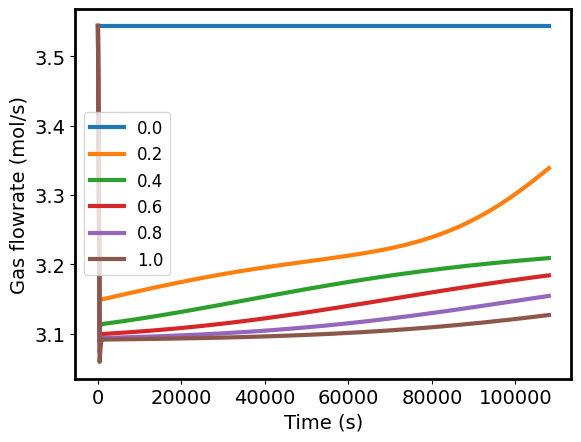

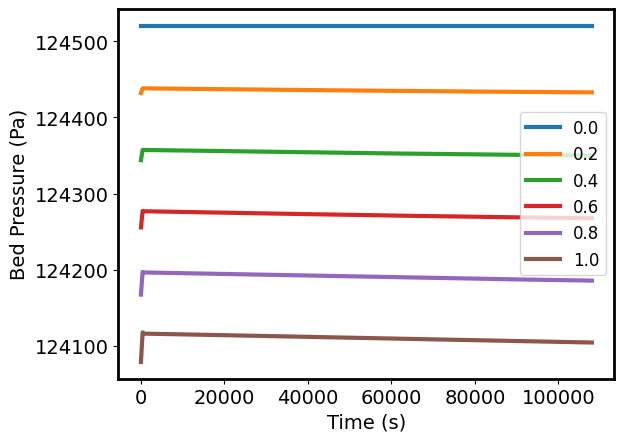

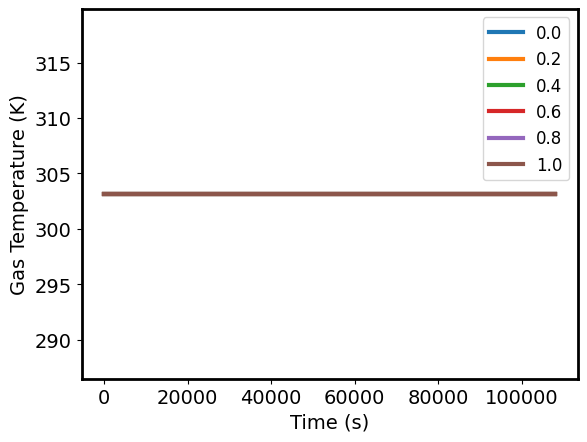

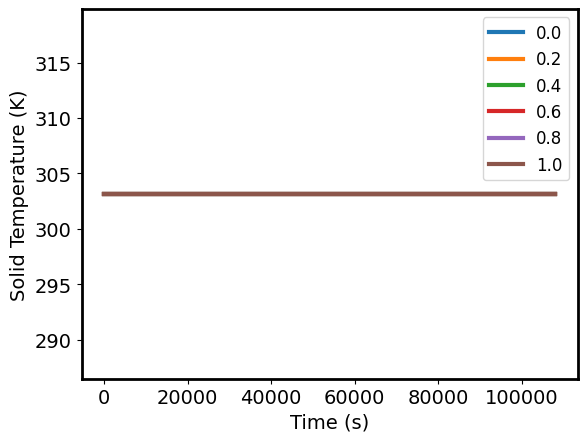

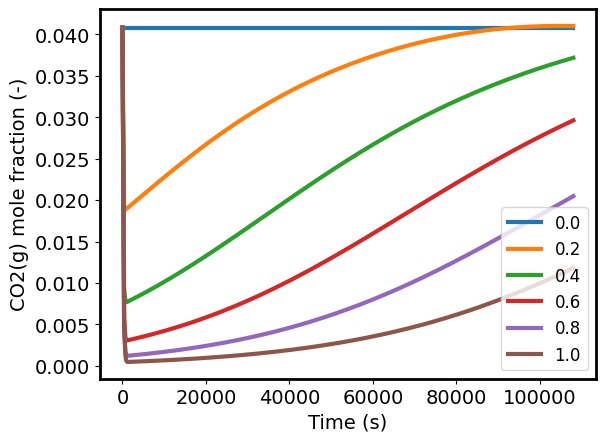

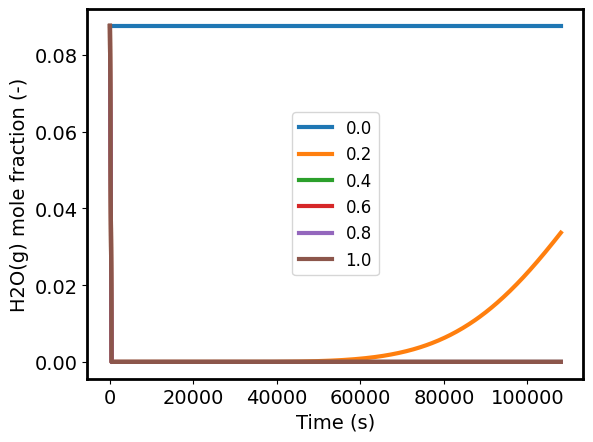

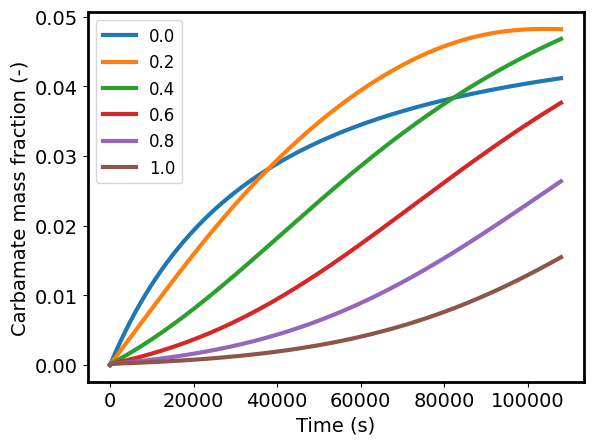

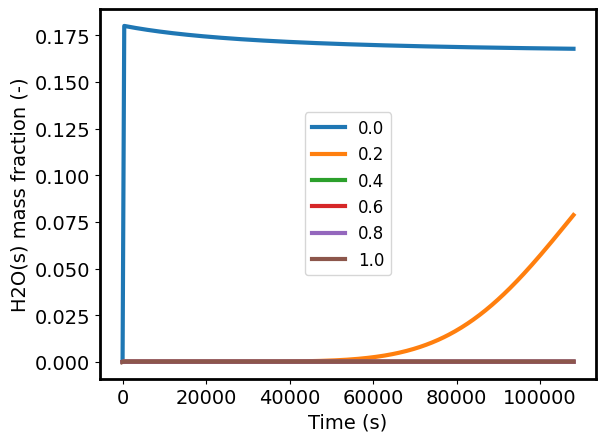

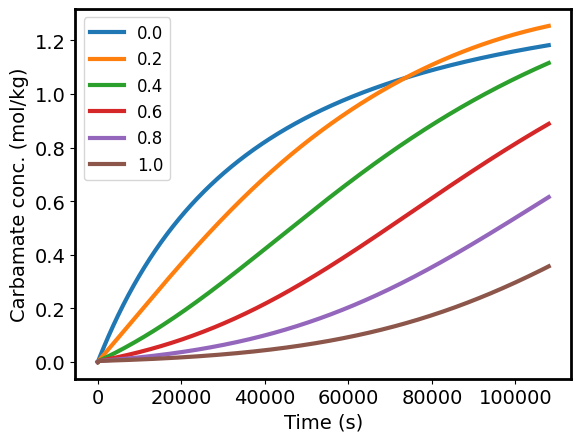

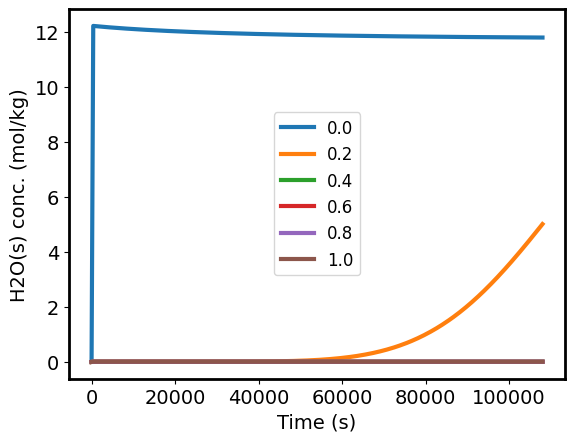

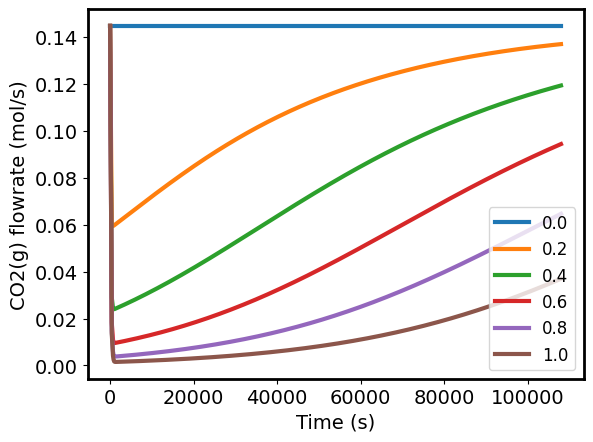

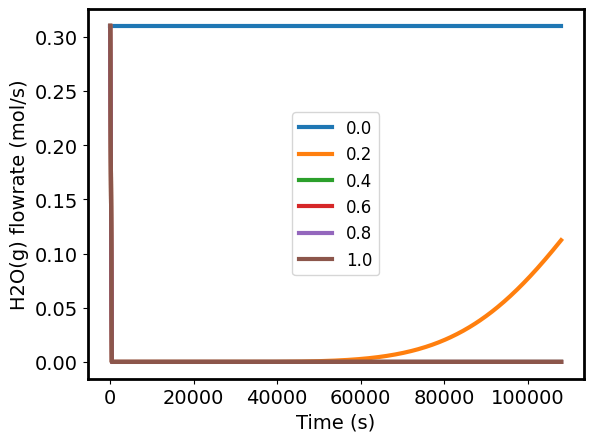

In [18]:
# Plot temporal result profiles
plot_results_temporal(m.fs_ads, tj_ads)

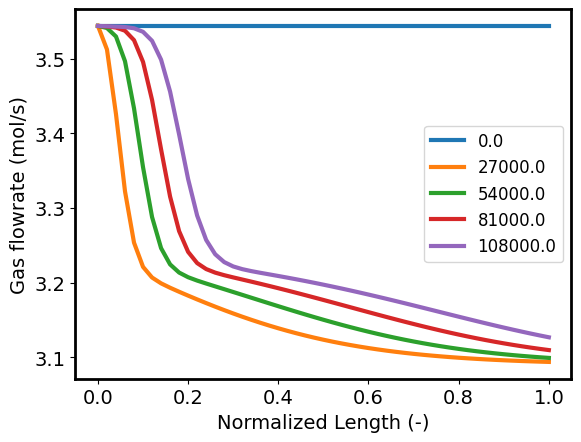

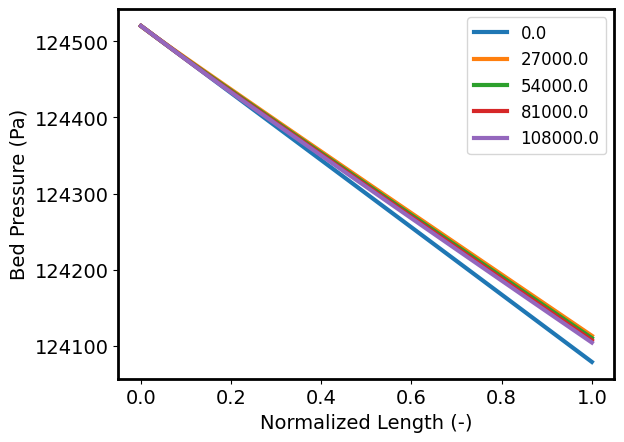

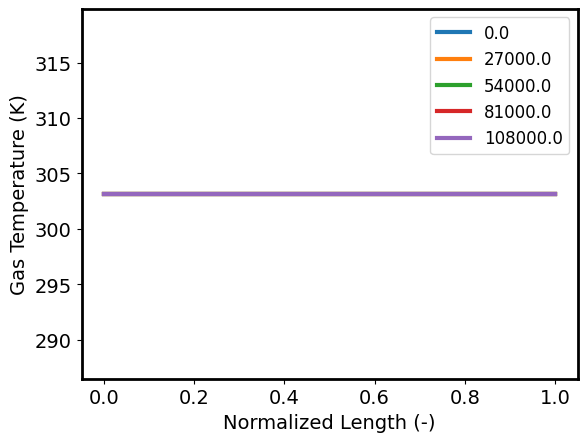

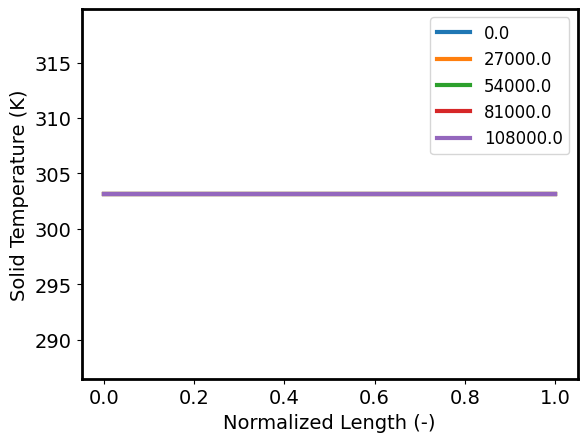

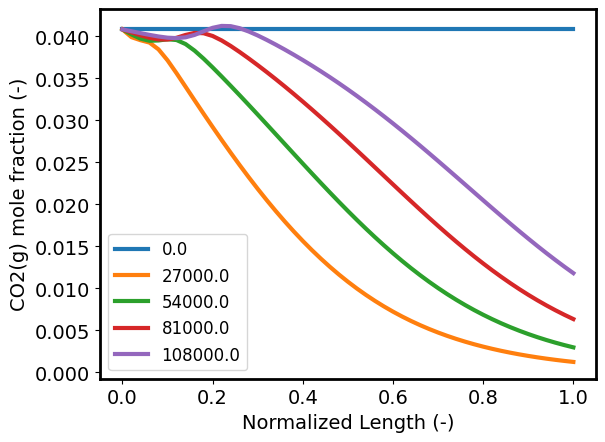

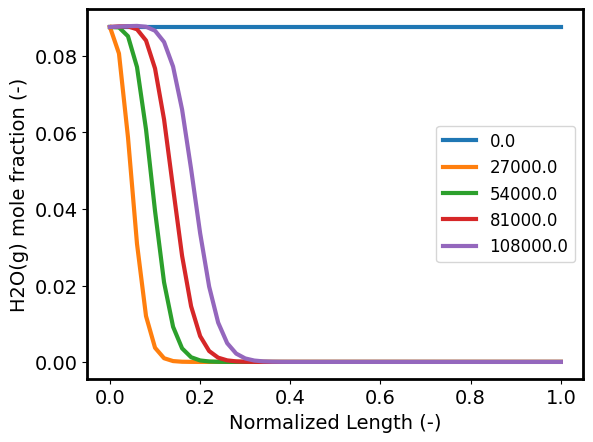

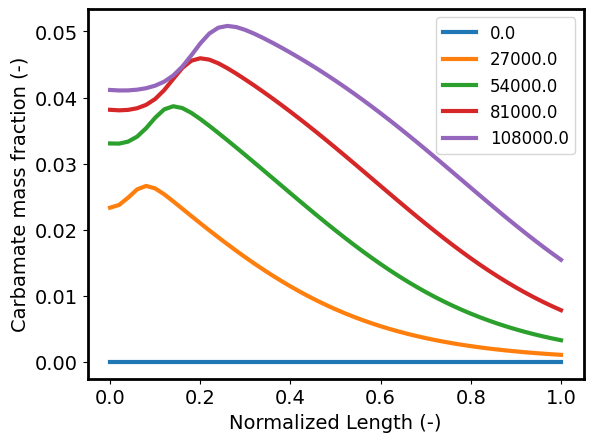

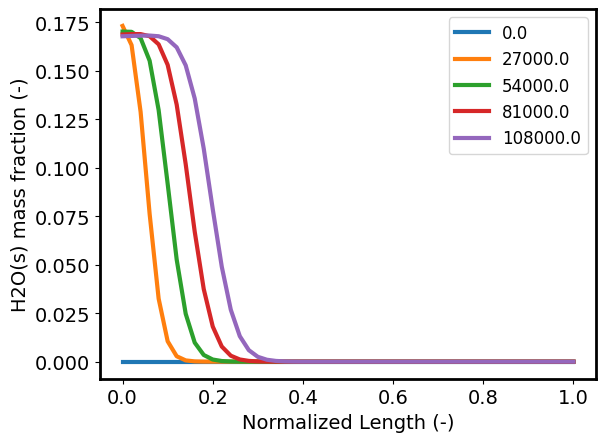

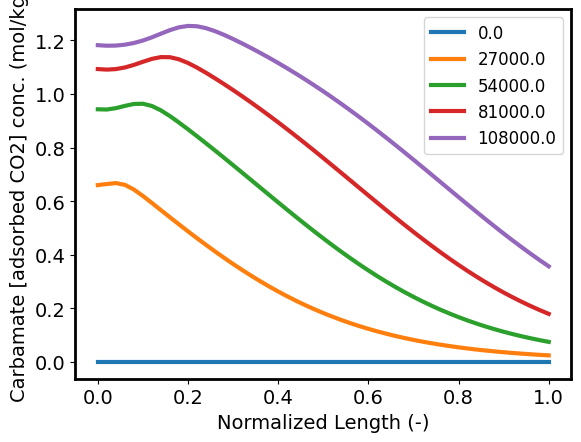

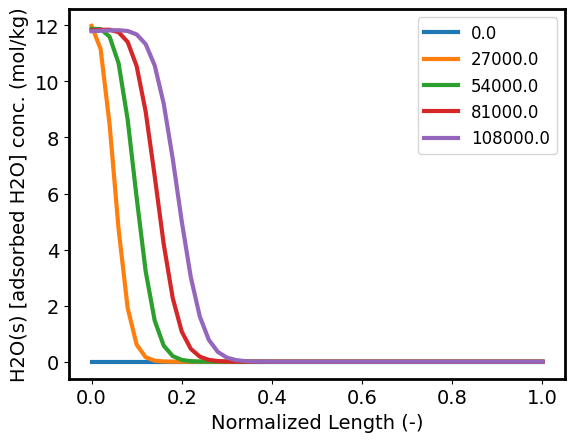

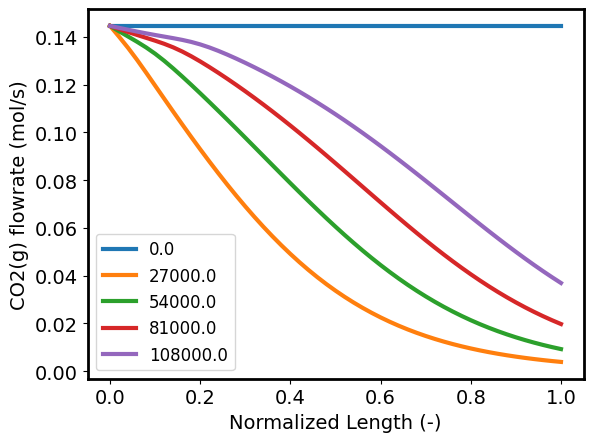

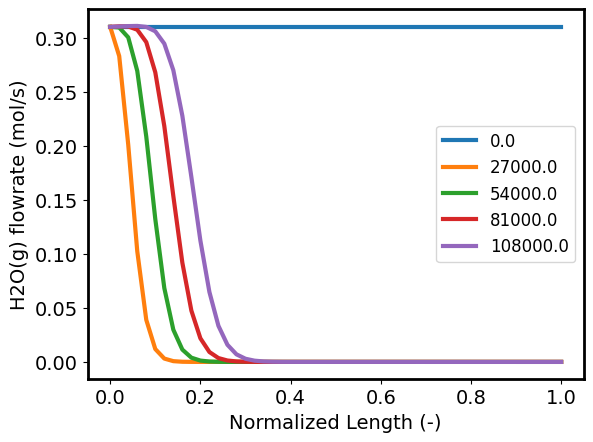

In [19]:
# Plot spatial result profiles
plot_results_spatial(m.fs_ads, tj_ads)

In [20]:
# Space and time discretization arguments
horizon = 7200  # s

# Setup for PETSc run
t_element_size = horizon  # s
ntfe = int(horizon / t_element_size)
time_set = list(np.linspace(0, horizon, ntfe + 1))

In [21]:
# Desorption operating conditions
desorption_temperature = 470  # K

gas_phase_state_dict_des = {
    "flow_mol": 10,  # mol/s
    "temperature": desorption_temperature,  # K
    "pressure": 1.06525e5,  # Pa
    "mole_frac_comp": {"CO2": 1e-8, "H2O": 1, "N2": 1e-8, "O2": 1e-8},  # [-]
}

In [22]:
# Create the desorption flowsheet
m.fs_des = FlowsheetBlock(dynamic=True, time_set=time_set, time_units=pyunits.s)

In [23]:
# Setup an instance of the 1D FixedBed model for the desorption simulation
m.fs_des = fb_model_setup(
    m.fs_des,
    ntfe,
    nxfe,
)

In [24]:
blk_des = m.fs_des.FB
tf_ads = tj_ads.time[-1]  # Get final time from adsorption trajectory results
tf_ads_index = tj_ads.time.index(tf_ads)  # Get index at final time
component_list = blk_des.config.solid_phase_config.property_package.component_list

for t in m.fs_des.time:
    for x in blk_des.length_domain:
        blk_des.solid_properties[t, x].temperature.set_value(desorption_temperature)
        blk_des.solid_properties[t, x].dens_mass_particle.set_value(
            tj_ads.get_vec(m.fs_ads.FB.solid_properties[tf_ads, x].dens_mass_particle)[
                tf_ads_index
            ]
        )
        for j in component_list:
            blk_des.solid_properties[t, x].mass_frac_comp[j].set_value(
                value(
                    tj_ads.get_vec(
                        m.fs_ads.FB.solid_properties[tf_ads, x].mass_frac_comp[j]
                    )[tf_ads_index]
                )
            )

In [25]:
fb_fix_conditions(
    m.fs_des,
    bed_diameter,
    bed_height,
    gas_phase_state_dict_des,
)

degrees of freedom =  0
inlet gas velocity =  0.00576901488631887  m/s
min. fluid velocity =  0.0091  m/s


In [26]:
iscale.calculate_scaling_factors(m.fs_des)

In [27]:
# Run start time
t_start_des = time.time()

# Initialize model
m.fs_des.FB.block_triangularization_initialize(
    gas_phase_state_args=gas_phase_state_dict_des,
    outlvl=idaeslog.DEBUG,
    solver=solver,
    calc_var_kwds=calc_var_kwds,
)

# Run end time
t_end_des = time.time()

# Initialization time
desorption_initialization_time = value(t_end_des - t_start_des)

In [28]:
# Run start time
t_start_des = time.time()

# Setup PETSc integrator and simulate desorption flowsheet
m.fs_des.time_var = Var(m.fs_des.time)
m.fs_des.time_var[0].fix(m.fs_des.time.first())

result_des = petsc.petsc_dae_by_time_element(
    m.fs_des,
    time=m.fs_des.time,
    timevar=m.fs_des.time_var,
    keepfiles=True,
    symbolic_solver_labels=True,
    skip_initial=False,
    ts_options={
        "--ts_type": "beuler",  # backward euler integration
        "--ts_dt": 200,  # set initial step to 200
        "--ts_rtol": 20,
        "--ts_monitor": "",
        "--ts_save_trajectory": 1,
        "--ksp_rtol": 1e-10,
        "--snes_type": "newtontr",  # newton trust region non-linear solver
        "--ts_monitor": "",
        "--ts_save_trajectory": 1,
        "--ts_max_snes_failures": 1000,
    },
)
tj_des = result_des.trajectory  # trajectory data

# Run end time
t_end_des = time.time()

# Initialization time
desorption_simulation_time = value(t_end_des - t_start_des)

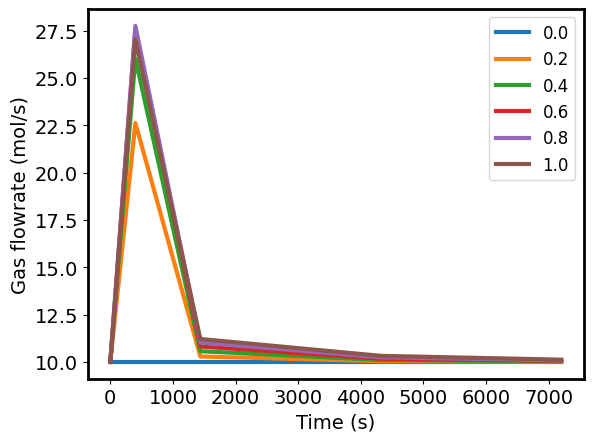

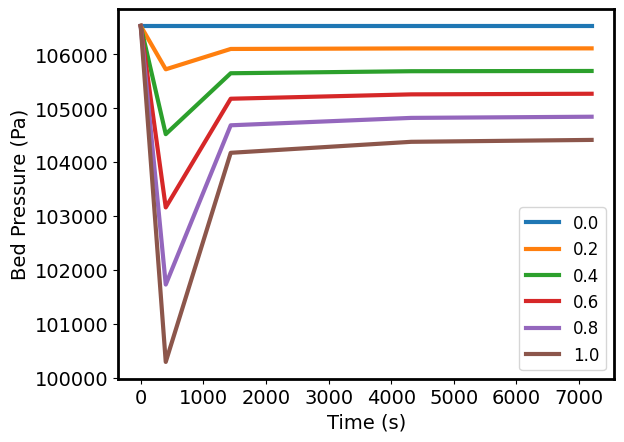

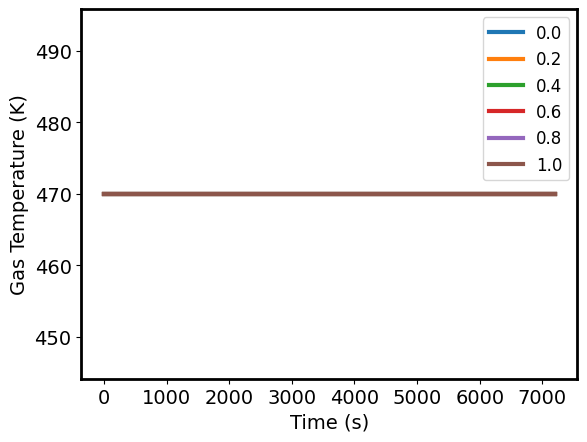

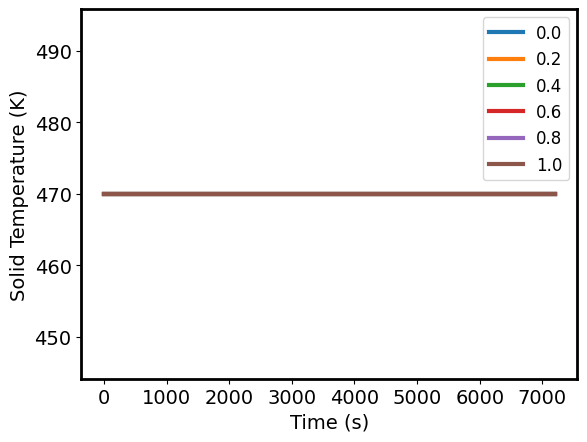

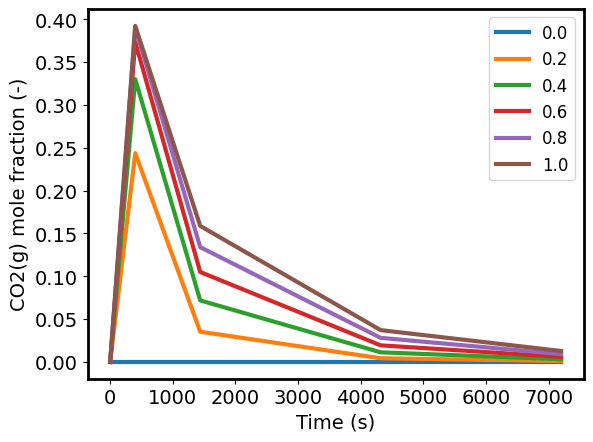

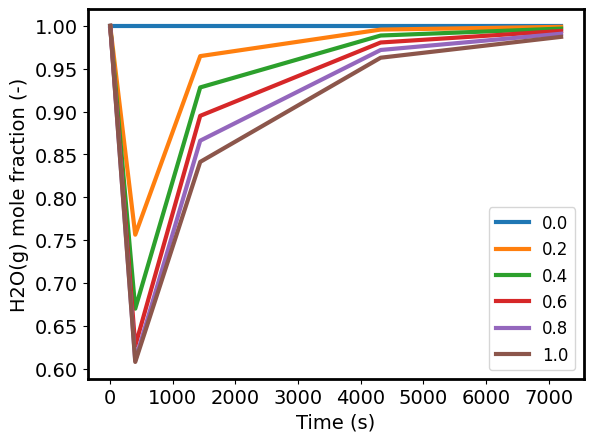

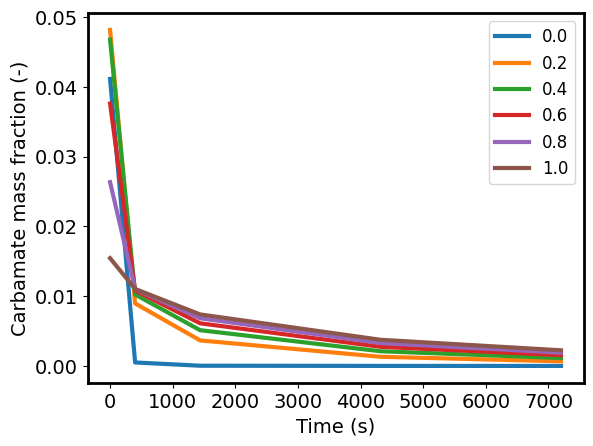

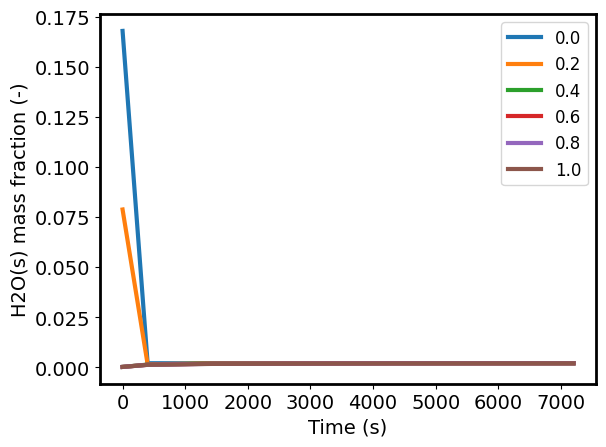

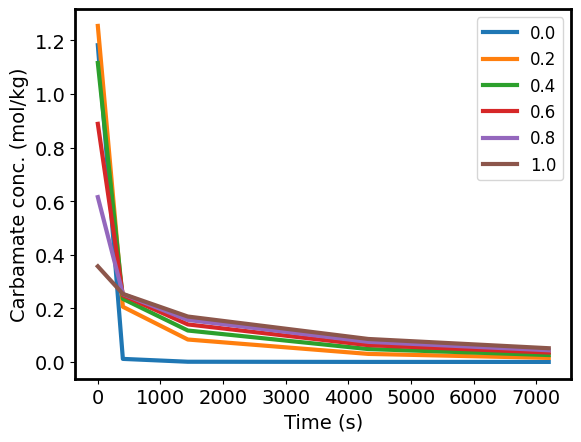

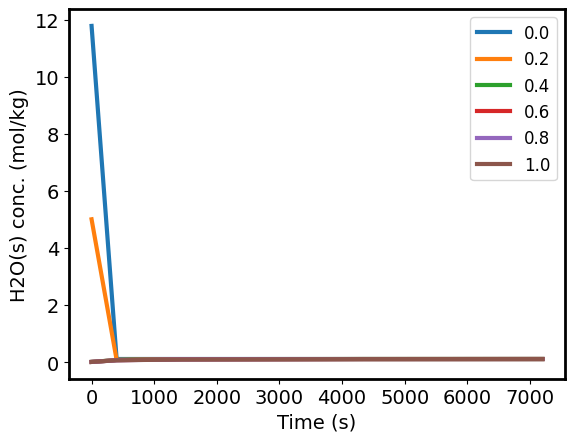

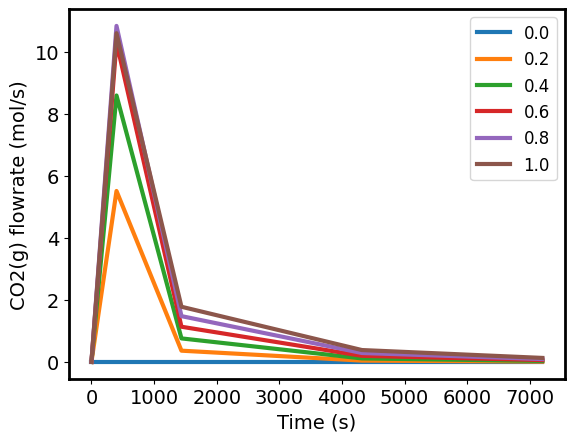

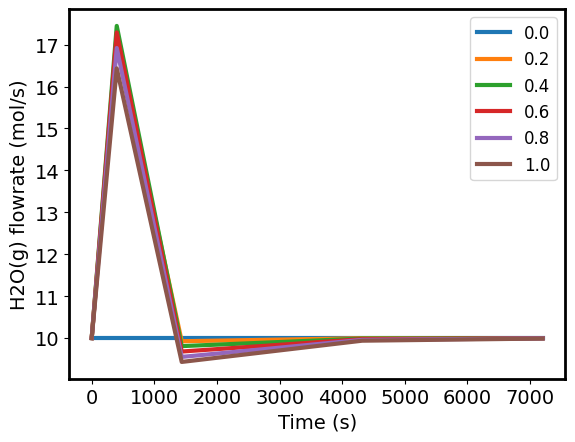

In [29]:
# Plot temporal result profiles
plot_results_temporal(m.fs_des, tj_des)

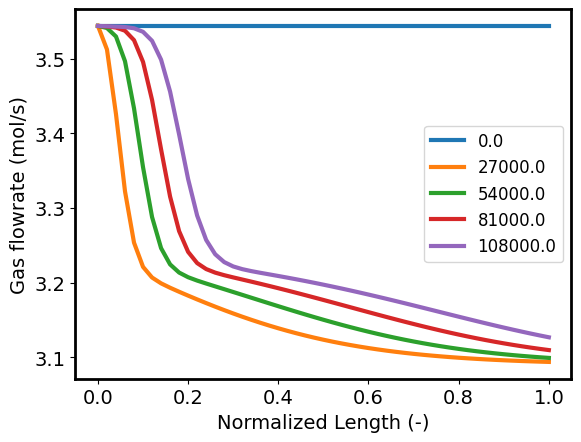

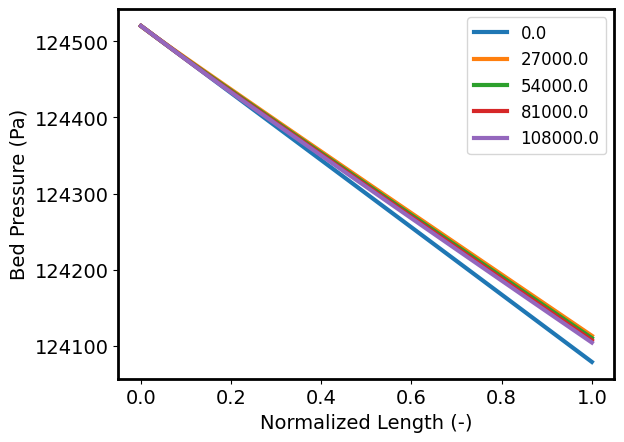

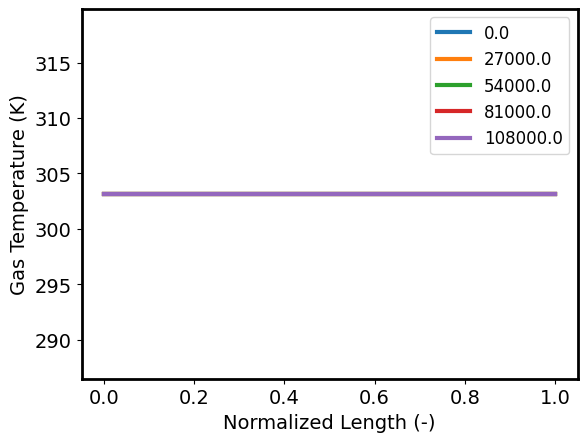

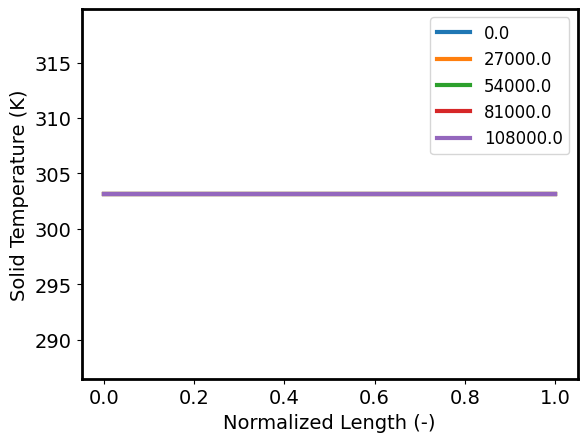

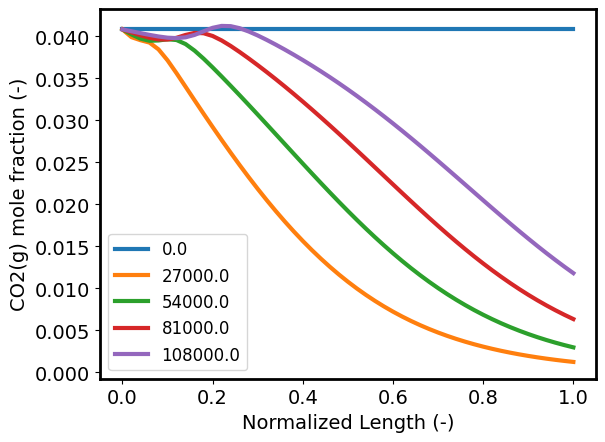

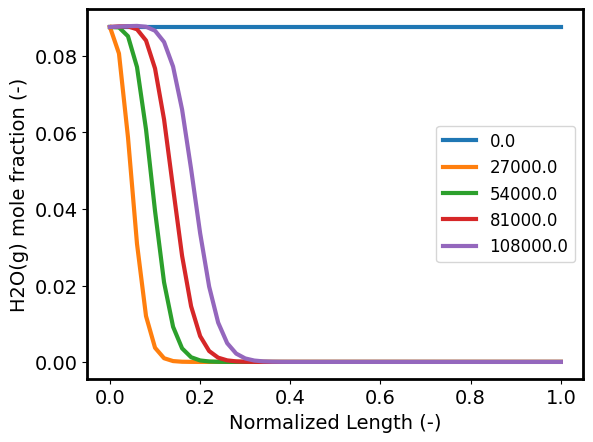

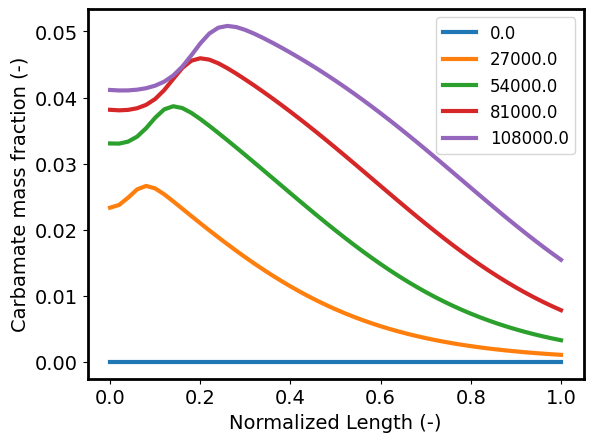

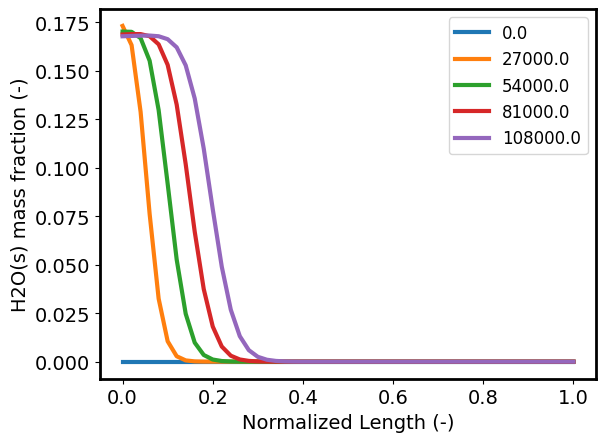

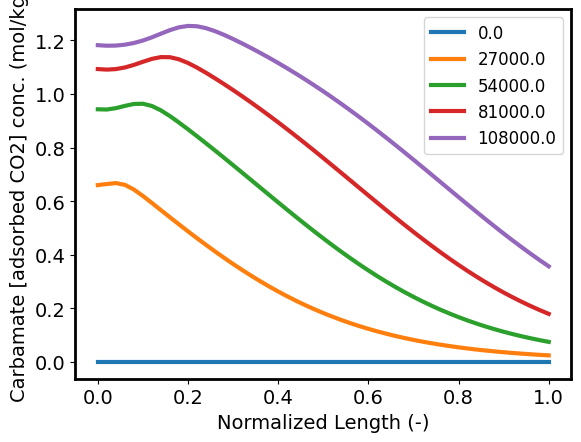

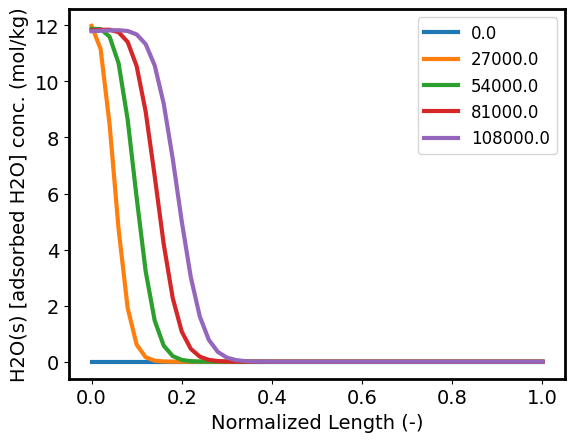

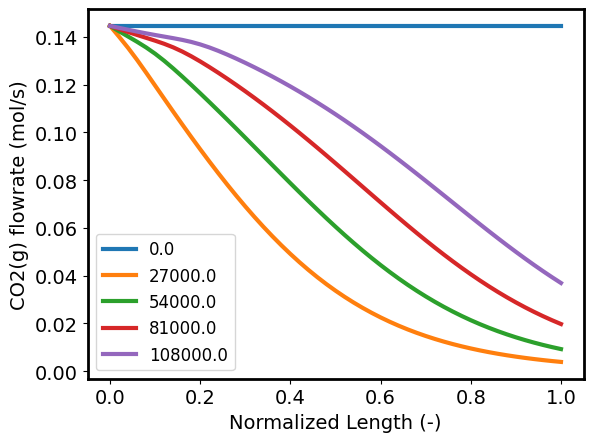

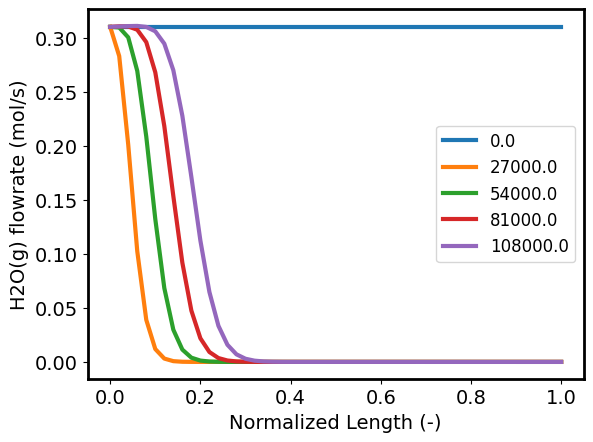

In [30]:
# Plot spatial result profiles
plot_results_spatial(m.fs_ads, tj_ads)

In [31]:
###########################################################################
#  Heat requirements
###########################################################################
heat_computation(m, tj_ads, tj_des, adsorption_temperature, desorption_temperature)

    taken


    taken


    taken


In [32]:
###########################################################################
#  Performance results
###########################################################################
performance_results(m, tj_ads, tj_des)

results_summary(m, adsorption_temperature, desorption_temperature)


Report fixed bed adsorption/desorption

Adsorption temperature [K]: 303.1500
Desorption temperature [K]: 470.0000
Column diameter [m]: 9.0000
Column length [m]: 1.0000
CO2 mole fraction at feed [%]: 4.0800
Feed flow rate [mol/s]: 3.5440
Feed velocity [m/s]: 0.0011
Minimum fluidization velocity [m/s]: 0.0091
Time of adsorption step [h]: 30.0000
Time of desorption step [h]: 2.0000
Cycle time [h]: 32.0000
CO2 input per cycle [kg/bed/cycle]: 687.1164
CO2 released per cycle [kg/bed/cycle]: 60.9462
CO2 adsorbed per cycle [kg/bed/cycle]: 632.8896
CO2 desorbed per cycle [kg/bed/cycle]: 612.9607
Purity [-]: 0.2150
Recovery [-]: 0.9685
Productivity [kg CO2/ton/h]: 979.7350
Specific energy [MJ/kg CO2]: 1.4651
Heat duty per bed [MW]: 0.1247
Cooling duty per bed [MW]: -0.0257
CO2 adsorbed per cycle CO2 balance [kg/bed/cycle]: 626.1702
CO2 adsorbed per cycle carbamate balance [kg/bed/cycle]: 632.8896
CO2 desorbed per cycle CO2 balance [kg/bed/cycle]: 1189.9355
CO2 desorbed per cycle carbamate balan

In [33]:
print("Adsorption initialization time: ", adsorption_initialization_time, " s")
print("Adsorption simulation time: ", adsorption_simulation_time, " s")
print()
print("Desorption initialization time: ", desorption_initialization_time, " s")
print("Desorption simulation time: ", desorption_simulation_time, " s")
print()
total_simulation_time = (
    adsorption_initialization_time
    + adsorption_simulation_time
    + desorption_initialization_time
    + desorption_simulation_time
)
print("Total simulation time: ", total_simulation_time, " s")

Adsorption initialization time:  5.624402761459351  s
Adsorption simulation time:  213.06072783470154  s

Desorption initialization time:  3.3875999450683594  s
Desorption simulation time:  4.828323125839233  s

Total simulation time:  226.90105366706848  s
